###  Imports

In [1]:
import pickle
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import chi2
import numpy as np

### Get data from Reddit

In [2]:
depressedData = pd.read_csv('./../../Data/depressed_posts.csv')
unpopularopinionData = pd.read_csv('./../../Data/unpopularopinion_posts.csv')
lonelyData = pd.read_csv('./../../Data/lonely_posts.csv')
machinelearningData = pd.read_csv('./../../Data/machinelearning_posts.csv')

### Clean r/unpopularopinion data

In [3]:
print(len(unpopularopinionData))

988


In [4]:
unpopularopinionData = unpopularopinionData[unpopularopinionData['Post'].notna()]
print(len(unpopularopinionData))

988


In [5]:
unpopularopinionData['Post'] = unpopularopinionData['Post'].astype(str)
print(len(unpopularopinionData))

988


In [6]:
allPosts = unpopularopinionData

urls = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})'
numbers = '\d+(\.\d+)?'
posessivePronouns = '’s'
apostrophe='’'
someSigns ='\\n|\\r'
punctuation = "[^\w\s]" 
whitespaces = '\s+'
leadTrailWhitespace = '^\s+|\s+?$'

allPosts['Post_Parsed'] = allPosts['Post'].str.lower()
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(urls,'url',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(numbers,'nmbr',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(posessivePronouns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(apostrophe,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(someSigns,'',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(punctuation,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(whitespaces,' ',regex=True)
allPosts['Post_Parsed'] = allPosts['Post_Parsed'].str.replace(leadTrailWhitespace,'',regex=True)

In [7]:
allPosts.head()

,Author,Subreddit,Date,Title,Post,Post_Parsed
0,usergirl2468,unpopularopinion,1.620531e+09,"Primarily, most people travel to show off.",I’m sure we’d all like to assume we are a part...,im sure wed all like to assume we are a part o...
1,NickBoi45,unpopularopinion,1.620569e+09,You DO stop being a parent,Since it’s Mother’s Day I thought it would be ...,since it mother day i thought it would be the ...
2,PitchTime9211,unpopularopinion,1.620552e+09,"Billie Ellish is a rаpper, not a singer.",She cannot sing to save her life and all her s...,she cannot sing to save her life and all her s...
3,MomsVertcoinWallet,unpopularopinion,1.620626e+09,Reddit is insanely hostile and toxic to the po...,Honestly I'm just waiting for the comments to ...,honestly i m just waiting for the comments to ...
4,Joruustheclone,unpopularopinion,1.620485e+09,Banana flavoured things are disgusting,Nothing with banana flavour actually tastes li...,nothing with banana flavour actually tastes li...


In [8]:
# Downloading punkt and wordnet from NLTK
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [9]:
# Saving the lemmatizer into an object
wordnet_lemmatizer = WordNetLemmatizer()

In [10]:
nrows = len(allPosts)
lemmatized_text_list = []

for post in allPosts.Post_Parsed:
    
    # Create an empty list containing lemmatized words
    lemmatized_list = []
    
    # Save the text and its words into an object
    text = post
    text_words = text.split(" ")

    # Iterate through every word to lemmatize
    for word in text_words:
        lemmatized_list.append(wordnet_lemmatizer.lemmatize(word, pos="v"))
        
    # Join the list
    lemmatized_text = " ".join(lemmatized_list)
    
    # Append to the list containing the texts
    lemmatized_text_list.append(lemmatized_text)

In [11]:
allPosts['Post_Parsed'] = lemmatized_text_list

In [12]:
allPosts.loc[1]['Post_Parsed']

'since it mother day i think it would be the perfect day to post this opinion but anyways people say you never stop be a parent which be simply not true why once all your kid move out you dont have to raise them anymore and technically that mean you be no longer a parent sure you may still be in touch with them but it not like you be actively feed them'

In [13]:
# stop words
with open('./../../stop_words_no_punct.data', 'rb') as filehandle:
    # read the data as binary data stream
    stop_words_no_punct = pickle.load(filehandle)

In [14]:
from nltk.tokenize import word_tokenize
post_without_stop_words = []

for post in allPosts.Post_Parsed:
    text_tokens = word_tokenize(post)
    tokens_without_stop_words = [word for word in text_tokens if not word in stop_words_no_punct]
    post_without_stop_words.append((" ").join(tokens_without_stop_words))

allPosts['Post_Parsed'] = post_without_stop_words

In [15]:
allPosts.loc[1]['Post_Parsed']

'since mother day think would perfect day post opinion anyways people say never stop parent simply true kid move raise anymore technically mean longer parent sure may still touch like actively feed'

In [16]:
unpopularopinionData = allPosts

unpopularopinionData.to_csv('unpopularopinion_posts_processed.csv', index=False)

### Generating Features

In [17]:
from nltk.tokenize import word_tokenize

def getWordFrequency(processedPostOutputFile):
    posts = pd.read_csv(processedPostOutputFile)

    allPostsConcat = ''
    for post in posts.Post_Parsed:
        if(type(post)==str):
            allPostsConcat+=post

    # create bag-of-words
    all_words = []

    words = word_tokenize(allPostsConcat)
    for word in words:
        all_words.append(word)

    all_words = nltk.FreqDist(all_words)
    
    return all_words

In [18]:
freqWordsUnpopularopinion = getWordFrequency('unpopularopinion_posts_processed.csv')

# print the total number of words and the 100 most common words
print('Number of words: {}'.format(len(freqWordsUnpopularopinion)))
print('Most common words: {}'.format(freqWordsUnpopularopinion.most_common(100)))

word_features_unpopularopinion = list(freqWordsUnpopularopinion.keys())[:1500]

Number of words: 9692
Most common words: [('people', 919), ('like', 869), ('get', 684), ('nmbr', 680), ('make', 531), ('think', 464), ('say', 403), ('go', 387), ('one', 356), ('want', 355), ('time', 353), ('even', 335), ('see', 328), ('would', 306), ('know', 303), ('feel', 293), ('good', 267), ('really', 254), ('much', 244), ('look', 241), ('use', 240), ('someone', 238), ('way', 221), ('need', 207), ('take', 206), ('something', 206), ('also', 196), ('life', 192), ('many', 191), ('things', 188), ('work', 187), ('bad', 185), ('kid', 178), ('come', 176), ('try', 172), ('day', 168), ('post', 162), ('better', 161), ('im', 159), ('game', 156), ('live', 155), ('give', 154), ('thing', 154), ('still', 149), ('lot', 149), ('mean', 144), ('show', 142), ('tell', 141), ('person', 139), ('love', 136), ('every', 136), ('talk', 128), ('find', 127), ('well', 127), ('everyone', 125), ('years', 124), ('stop', 123), ('point', 123), ('care', 120), ('could', 119), ('put', 118), ('first', 118), ('watch', 117

[nltk_data] Downloading package webtext to
[nltk_data]     C:\Users\aligo\AppData\Roaming\nltk_data...
[nltk_data]   Package webtext is already up-to-date!


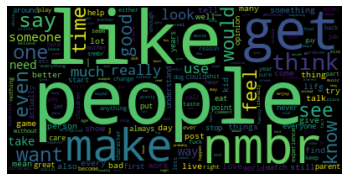

In [19]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt
 
nltk.download('webtext')
data_analysis = freqWordsUnpopularopinion
 
filter_words = dict([(m, n) for m, n in data_analysis.items() if len(m) > 2])
 
wcloud = WordCloud().generate_from_frequencies(filter_words)
 
# Plotting the wordcloud
plt.imshow(wcloud, interpolation="bilinear")
 
plt.axis("off")
(-0.5, 399.5, 199.5, -0.5)
plt.show()

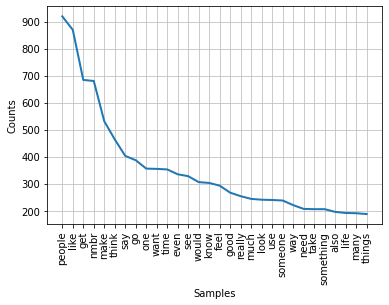

In [20]:
import matplotlib.pyplot as plt
freqWordsUnpopularopinion.plot(30,cumulative=False)
plt.show()